## Figure 7 - Conceptual Model of the Magmatic-Hydrothermal System


3D source shape using Adobe Illustrator:   
a. Cuboid: https://www.webfx.com/blog/web-design/create-a-3d-shipping-package-box-icon-in-illustrator/  
b. Sphere: http://www.adobepress.com/articles/article.asp?p=1339477&seqNum=4

In [19]:
%matplotlib inline
import os
import h5py
import numpy as np
import scipy.io as sio
from matplotlib import pyplot as plt, ticker
from mintpy.utils import ptime, readfile, writefile, utils as ut, plot as pp
from mintpy.defaults.plot import *
from mintpy import mask, save_gmt, view

work_dir = os.path.expanduser('~/Documents/Paper/2019_Kirishima/figs_src/conceptual_model')
os.chdir(work_dir)
print('Go to directory', work_dir)

dem_file = os.path.expanduser('~/Documents/Paper/2019_Kirishima/figs_src/data/dem.wgs84')
dem, atr = readfile.read(dem_file)
coord = ut.coordinate(atr)

## Define transection location
profile_lalos = [
    [31.9290, 130.8130],
    [31.9470, 130.8535],   #[31.9480, 130.8535],
    [31.8500, 130.9350],
]

Go to directory /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/conceptual_model


### Version 2 - 3D topographic using GMT/grdview

delete exsited file: /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/conceptual_model/maskCut.h5
create HDF5 file: /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/conceptual_model/maskCut.h5 with w mode
create dataset /.wgs84 of bool       in size of (3600, 5400)         with compression=None
finished writing to /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/conceptual_model/maskCut.h5
masking dem from dem.h5 ...
delete exsited file: /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/conceptual_model/dem_msk.h5
create HDF5 file: /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/conceptual_model/dem_msk.h5 with w mode
create dataset /dem of float32    in size of (3600, 5400)         with compression=None
finished writing to /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/conceptual_model/dem_msk.h5
Done.


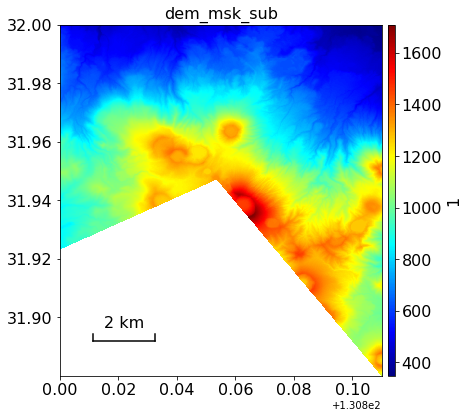

writing >>> dem_msk.grd
Done.
grdview: Read intensity grid header from file topo_i.nc
grdview: The y-coordinates and range attribute are in conflict; must rely on coordinates only
grdview: Guessing of registration in conflict between x and y, using gridline
grdview: Processing shape grid
grdview: Processing illumination grid
grdview: Start creating PostScript plot
grdview: Get and store projected vertices
grdview: Start rasterization
grdview: Creating PostScript image [color image]
grdview: Done!


In [20]:
## cut DEM file

# 1. prepare cut mask
length, width = dem.shape
yy, xx = np.mgrid[0:length-1:length*1j, 0:width-1:width*1j].astype(np.int16)

msk = np.ones((length, width), np.int16)
for i in range(len(profile_lalos)-1):
    # convert lalo to yx
    y0, x0 = coord.geo2radar(profile_lalos[i][0], profile_lalos[i][1])[0:2]
    y1, x1 = coord.geo2radar(profile_lalos[i+1][0], profile_lalos[i+1][1])[0:2]

    # calculate the line parameter
    a = (y1 - y0) / (x1 - x0)
    b = y0 - a * x0

    # update mask
    msk *= yy > a * xx + b
msk = msk == 0

# display
display = False
if display:
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[10,3])
    axs[0].imshow(dem, cmap='jet')
    im = axs[1].imshow(msk, cmap='gray')
    plt.show()

# 2. write cut mask to file
msk_file = os.path.abspath('maskCut.h5')
writefile.write(msk, msk_file, atr)

# 3. mask dem file
dem_msk_file = os.path.abspath('dem_msk.h5')
scp_args = 'dem.h5 -m {} -o {}'.format(msk_file, dem_msk_file)
mask.main(scp_args.split())

# 3.1 plot dem file 130.8/130.91/31.86/32.0
scp_args = '{} --figsize 6 8 --sub-lat 31.88 32.0 --sub-lon 130.8 130.91 --noverbose '.format(dem_msk_file)
view.main(scp_args.split())

# 4. convert to GMT format
save_gmt.main(['dem_msk.h5'])

# 5. Run GMT script
!./dem3D.sh
!open dem3D.tif

### Version 1 - Topographic Profile

save figure to /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/conceptual_model/topo_transect.png


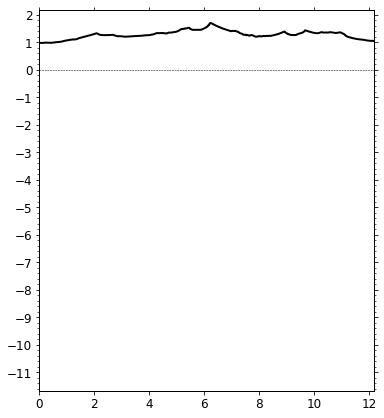

In [88]:
## Read DEM transection
transect = {}
start_distance = 0
for i in range(len(profile_lalos)-1):
    lalo0 = profile_lalos[i]
    lalo1 = profile_lalos[i+1]
    seg = ut.transect_lalo(dem, atr, start_lalo=lalo0, end_lalo=lalo1)
    seg['distance'] += start_distance
    print('segment max distance: {:.1f} m'.format(np.max(seg['distance'])))
    delta_x = lalo1[1] - lalo0[1]
    delta_y = lalo1[0] - lalo0[0]
    #az_angle = 

    # add segment to transection
    if i == 0:
        transect['value'] = np.array(seg['value'], dtype=np.float32)
        transect['distance'] = np.array(seg['distance'], dtype=np.float32)
    else:
        transect['value'] = np.concatenate((transect['value'], seg['value'][1:]))
        transect['distance'] = np.concatenate((transect['distance'],seg['distance'][1:]))

    # update start_distance for the next segment
    start_distance = transect['distance'][-1]

transect['distance'] /= 1000.  #km
transect['value'] /= 1000.  #km

## plot
fig, ax = plt.subplots(figsize=[6,7])
ax.plot(transect['distance'], transect['value'], c='k', lw=2)
ax.axhline(0, ls='--', c='k', lw=0.5)

# axis format
ax.set_aspect('equal', 'datalim')
ax.set_ylim(-11.5, 2)
ax.set_xlim(0,np.max(transect['distance']))

#ax.set_ylabel('Depth [km]', fontsize=font_size)
ax.tick_params(which='both', direction='out', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)

# output
out_file = os.path.abspath('topo_transect.png')
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to', out_file)
plt.show()